# 18. 추론 분석

- 추론모델은 일반적으로 예측뿐만 아니라 계수 값이나 기타 파라미터와 같은 모델의 일부 구성 요소에 대한 추론이나 판단을 위해 생성
    - 이러한 결과는 미리 정의된 질문이나 가설에 답하는 데 자주 사용
- **예측모델에서는 홀드아웃 데이터에 대한 예측을 사용하여 모델 품질을 검증하거나 특성화하지만,**
    
    **추론방법은 모델을 적합화하기 전에 만들어진 확률적 또는 구조적 가정을 검증하는 데 중점**

    - 예) 단순선형 회귀분석에서 잔차 값이 독립적이고, 일정한 분산을 갖는 가우스 분포를 따른다는 가정
    
    $\rightarrow$ 모델 분석을 위해 이 가정에 대한 신빙성을 부여할 수 있는 과학적 또는 도메인 지식이 있을 수 있지만, 일반적으로 적합모델의 잔차를 검사하여 가정이 좋은 아이디어인지 확인


In [2]:
library(tidymodels)
library(poissonreg)
library(infer)
tidymodels_prefer()
theme_set(theme_bw())

In [3]:
data("bioChemists", package = "pscl")

<br>

## 18.01. 개수 데이터에 대한 추론

In [8]:
bioChemists %>% head

,art,fem,mar,kid5,phd,ment
,<int>,<fct>,<fct>,<dbl>,<dbl>,<int>
1,0,Men,Married,0,2.52,7
2,0,Women,Single,0,2.05,6
3,0,Women,Single,0,3.75,6
4,0,Men,Married,1,1.18,3
5,0,Women,Single,0,3.75,26
6,0,Women,Married,2,3.59,2


- `art` (출판물의 수) 변수에 대한 분포

    $\rightarrow$ **`art`변수는 개수와 관련된 변수이므로, `art`변수의 분포에 대한 일반적인 가정은 포아송 분포**

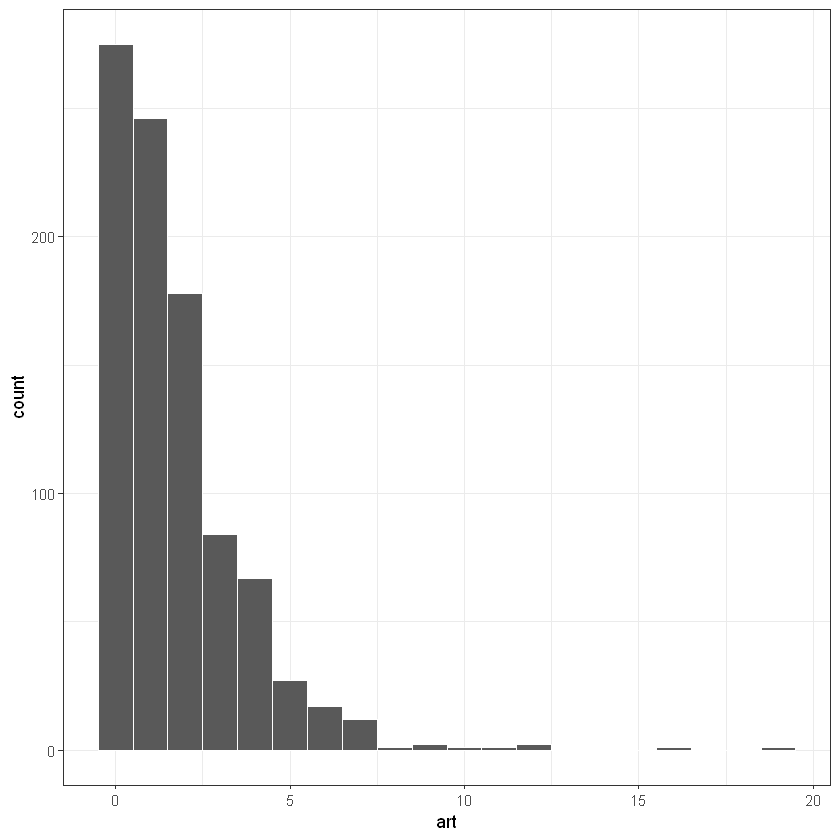

In [6]:
ggplot(bioChemists, aes(x = art)) + 
    geom_histogram(binwidth = 1, color = "white")

<br>

### 이표본 검정

- 데이터에는 남성이 더 많으며, `art`의 수 또한 더 많음

In [9]:
bioChemists %>%
    group_by(fem) %>%
    summarise(counts = sum(art), n = length(art))

fem,counts,n
<fct>,<int>,<int>
Men,930,494
Women,619,421


<br>

#### 포아송 검정
- 남성과 여성의 `art` 분포간 평균에 대한 비교
- p-value < 0.05 $\rightarrow$ 귀무가설 기각

    $\rightarrow$ 남성과 여성의 `art`분포 평균은 다르다

$$\begin{align}
H_0&: \lambda_m = \lambda_f \notag \\
H_a&: \lambda_m \ne \lambda_f \notag
\end{align}$$

In [13]:
poisson.test(c(930, 619)) %>% tidy()

estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1.502423,930,2.727173e-15,774.5,1.355716,1.665905,Comparison of Poisson rates,two.sided


<br>

#### 부트스트랩
- 두 그룹 간의 평균 차이 계산

In [14]:
library(infer)

In [24]:
observed <- bioChemists %>%
    specify(art ~ fem) %>%
    calculate(stat = "diff in means", order = c("Men", "Women"))

In [25]:
observed

stat
<dbl>
0.4122823


- 부트스트랩 분포를 생성하여, 평균에 대한 신뢰구간 계산

In [26]:
set.seed(2101)

In [27]:
bootstrapped <- bioChemists %>%
    specify(art ~ fem) %>%
    generate(reps = 2000, type = "bootstrap") %>%
    calculate(stat = "diff in means", order = c("Men", "Women"))

In [29]:
bootstrapped %>% dim
bootstrapped %>% head

[1] 2000    2

replicate,stat
<int>,<dbl>
1,0.4673617
2,0.1068764
3,0.4665542
4,0.3083260
5,0.3686163
6,0.4277987


- 95% 신뢰구간

In [32]:
percentile_ci <- get_ci(bootstrapped)
percentile_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.1580736,0.652879


- 두 그룹간 평균차이에 대한 부투스트랩 분포
- 부트스트랩에 의한 분포에는 0이 포함되지 않음

    $\rightarrow$ 남성이 여성보다 더 많은 출판물을 발행 하였음

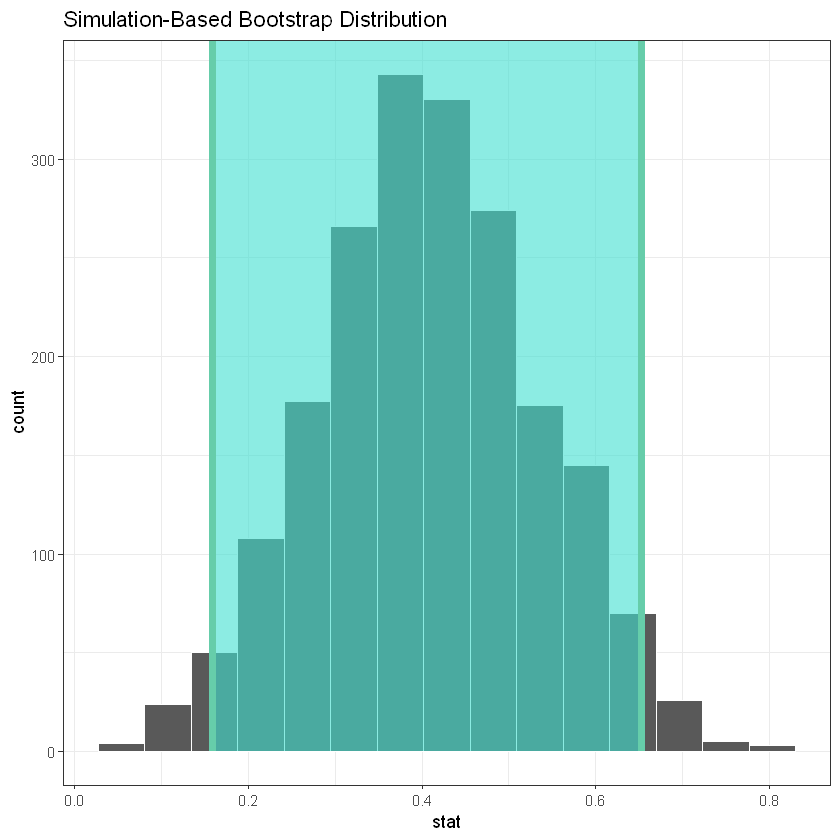

In [33]:
visualize(bootstrapped) +
    shade_confidence_interval(endpoints = percentile_ci)

#### 순열검정을 통한 p-value 계산


- 귀무가설 ($\lambda_m = \lambda_f$)에서의, 두 그룹간 평균차에 대한 부트스트랩 분포

In [55]:
set.seed(2102)

In [56]:
permuted <- bioChemists %>%
    specify(art ~ fem) %>%
    hypothesise(null = "independence") %>%
    generate(reps = 2000, type = "permute") %>%
    calculate(stat = "diff in means", order = c("Men", "Women"))

In [57]:
permuted %>% dim
permuted %>% head

[1] 2000    2

replicate,stat
<int>,<dbl>
1,0.201102061
2,-0.133266658
3,0.108710704
4,-0.194860896
5,-0.001279006
6,-0.102469539


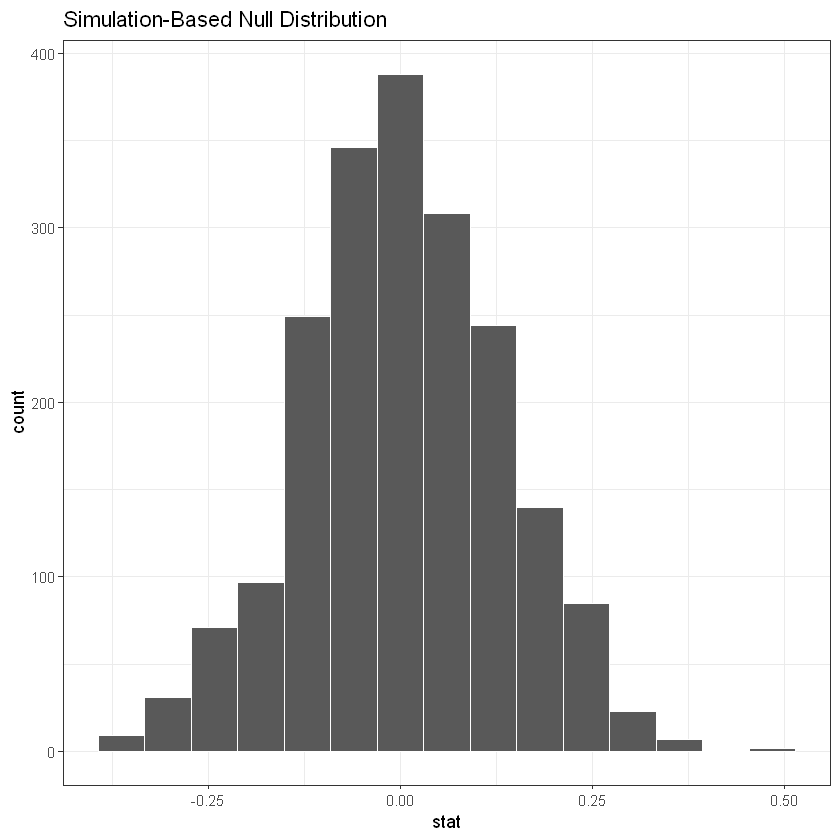

In [61]:
visualize(permuted)

- 두 그룹간 실제 평균 차이

In [62]:
observed

stat
<dbl>
0.4122823


- **p-value : 귀무가설 하에서의 분포에서, 실제 평균 차이의 분위수**
    
    $\rightarrow$ **귀무가설이 참이라면, 실제 관측값을 관찰할 확률이 매우 낮음**
    
    $\rightarrow$ **귀무가설은 참이 아님**

In [63]:
permuted %>%
    get_p_value(obs_stat = observed, direction = "two-sided")

p_value
<dbl>
0.002


In [65]:
permuted %>%
    get_p_value(obs_stat = observed, direction = "two-sided")

p_value
<dbl>
0.002


<br>

## 18.02. 로그-선형 모델


<br>

### 일반화 선형회귀모델

- `art`가 포아송 분포를 따른다는 가정하에서의, 일반화 선형회귀 (GLM)

$$\log(\lambda) = \beta_0 + \beta_1x_1 + \ldots + \beta_px_p$$

<br>

#### GLM 방식

In [68]:
library(poissonreg)

In [69]:
log_lin_spec <- poisson_reg()

In [72]:
log_lin_fit <-  log_lin_spec %>% fit(art ~ ., data = bioChemists)

- 각 설명변수별 회귀계수 $\beta_j$에 대한 p-value는 아래의 검정에 대한 p-value

$$\begin{align}
H_0&: \beta_j = 0 \notag \\
H_a&: \beta_j \ne 0 \notag
\end{align}$$

- `phd`변수는 유의하지 않은 변수

In [73]:
log_lin_fit %>% tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.30461683,0.102981443,2.9579779,3.096643e-03
femWomen,-0.22459423,0.054613488,-4.1124315,3.915137e-05
marMarried,0.15524338,0.061374395,2.5294487,1.142419e-02
kid5,-0.18488270,0.040126898,-4.6074506,4.076360e-06
phd,0.01282258,0.026397045,0.4857582,6.271386e-01
ment,0.02554275,0.002006073,12.7327095,3.890982e-37


<br>

#### 부트스트랩 방식
- 각 회귀계수에 대한 부트스트랩 분포
- **`phd`변수의 신뢰구간은 0을 포함 $\rightarrow$ 유의하지 않음을 의미**

In [75]:
set.seed(2103)

In [76]:
glm_boot <- reg_intervals(art ~ ., data = bioChemists, model_fn = "glm", family = poisson)
glm_boot

term,.lower,.estimate,.upper,.alpha,.method
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
femWomen,-0.3578439236,-0.22586387,-0.08560531,0.05,student-t
kid5,-0.2983361090,-0.18424684,-0.07885309,0.05,student-t
marMarried,0.0002642048,0.15481715,0.31744224,0.05,student-t
ment,0.0181749990,0.02563583,0.03220318,0.05,student-t
phd,-0.0706807825,0.01300334,0.10191467,0.05,student-t


<br>

#### GLM방식과 부트스트랩 방식의 각 회귀계수별 신뢰구간 비교

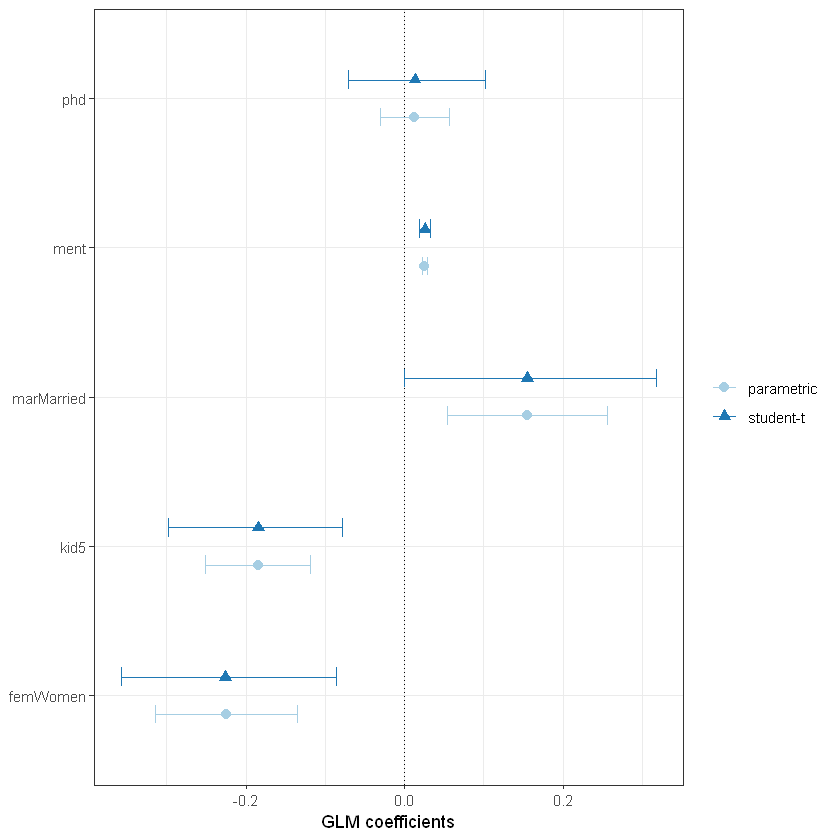

In [77]:
glm_boot %>% 
    select(term, method = .method, .estimate, .lower, .upper) %>% 
    bind_rows(
        tidy(log_lin_fit, conf.int = TRUE, conf.level = 0.90) %>% 
            filter(term != "(Intercept)") %>% 
            mutate(method = "parametric") %>% 
            select(term, method, .estimate = estimate, .lower = conf.low, .upper = conf.high)
    )%>%
    ggplot(aes(x = .estimate, y = term, color = method, pch = method)) +
    geom_vline(xintercept = 0, lty = 3) +
    geom_point(size = 2.5, position = position_dodge(width = 1 / 2)) +
    geom_errorbar(aes(xmin = .lower, xmax = .upper),
                  width = 1 / 4,
                  position = position_dodge(width = 1 / 2))  +
    labs(x = "GLM coefficients", y = NULL, color = NULL, pch = NULL) + 
    scale_color_brewer(palette = "Paired")

<br>

### 변수 선택

<br>

#### 우도비 검정
- 우도비검정(Likelihood Ratio Test, LRT)은 두 개 이상의 통계 모델 간에 어느 것이 더 데이터를 잘 설명하는지를 평가하는 통계적 검정 방법
- 주로 모델 간 비교나 모델의 적합성을 평가할 때 사용

<br>

- **중첩모델 간에 우도비 검정 (LRT)를 수행**
    - 모델 1 : `phd`가 제외된 모델
    - 모델 2 : `phd`가 포함된 모델
    

$$\begin{align}
H_0&: \beta_{phd} = 0 \notag \\
H_a&: \beta_{phd} \ne 0 \notag
\end{align}$$

In [78]:
log_lin_reduced <- log_lin_spec %>% 
    fit(art ~ ment + kid5 + fem + mar, data = bioChemists)

#### 두 모델간 우도비 검정
- **p-value > 0.05 $\rightarrow$ 귀무가설 채택**

In [81]:
anova(
    extract_fit_engine(log_lin_reduced),
    extract_fit_engine(log_lin_fit),
    test = "LRT"
) %>%
    tidy()

term,df.residual,residual.deviance,df,deviance,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
art ~ ment + kid5 + fem + mar,910,1634.607,NA,NA,NA
art ~ fem + mar + kid5 + phd + ment,909,1634.371,1,0.2362028,0.6269622


<br>

## 18.04. 더욱 복잡한 모델
- **개수 데이터의 경우 관측값이 0인 수가, 포아송 분포에서 규정하는 것 보다 더 큰 경우가 존재**

    $\rightarrow$ **ZIP (Zero-Inflated Poisson, 영-팽창 포아송) 모델**
    
$$\lambda = 0 \pi + (1 - \pi) \lambda_{nz}$$

- $\lambda$ : 포아송 분포의 평균에 대한 파라미터
- $\pi$ : 관측값이 0일 확률에 대한 파라미터

$$\begin{align}
\log(\lambda_{nz}) &= \beta_0 + \beta_1x_1 + \ldots + \beta_px_p \notag \\
\log\left(\frac{\pi}{1-\pi}\right) &= \gamma_0 + \gamma_1z_1 + \ldots + \gamma_qz_q \notag
\end{align}$$

- $x$와 $z$는 상호 배타적일 필요는 없음

In [82]:
zero_inflated_spec <- poisson_reg() %>% set_engine("zeroinfl")

- **`fem`, `mar`, `kid5`, `ment`는 모델의 제로-인플레이션 부분 (관측값이 0일 확률)에 대한 적합에 포함**
- **`fem`, `mar`, `kid5`, `phd`, `ment`는 ZIP모델의 개수에 대한 적합에 포함**

In [83]:
zero_inflated_fit <- zero_inflated_spec %>% 
    fit(art ~ fem + mar + kid5 + ment | fem + mar + kid5 + phd + ment,
        data = bioChemists)

In [88]:
zero_inflated_fit

parsnip model object


Call:
pscl::zeroinfl(formula = art ~ fem + mar + kid5 + ment | fem + mar + 
    kid5 + phd + ment, data = data)

Count model coefficients (poisson with log link):
(Intercept)     femWomen   marMarried         kid5         ment  
    0.62116     -0.20907      0.10505     -0.14281      0.01798  

Zero-inflation model coefficients (binomial with logit link):
(Intercept)     femWomen   marMarried         kid5          phd         ment  
   -0.60865      0.10931     -0.35292      0.21946      0.01236     -0.13509  


<br>

#### 모델비교
- `phd`가 제거된 축소모델과의 AIC기준 비교

In [95]:
zero_inflated_fit %>% extract_fit_engine() %>% AIC()

[1] 3231.585

In [96]:
log_lin_reduced   %>% extract_fit_engine() %>% AIC()

[1] 3312.349

- **하지만 AIC에 따른 비교는, 모델간 실제로 얼마나 다른지 판단하기 어려움**

    $\rightarrow$ **두 모델 각각에 대해 다수의 리샘플링 & 적합을 시행**
   

In [97]:
zip_form <- art ~ fem + mar + kid5 + ment | fem + mar + kid5 + phd + ment
glm_form <- art ~ fem + mar + kid5 + ment

In [98]:
set.seed(2104)
bootstrap_models <- bootstraps(bioChemists, times = 2000, apparent = TRUE) %>%
    mutate(
        glm = map(splits, ~ fit(log_lin_spec,       glm_form, data = analysis(.x))),
        zip = map(splits, ~ fit(zero_inflated_spec, zip_form, data = analysis(.x)))
    )

In [99]:
print(bootstrap_models)

# Bootstrap sampling with apparent sample 
# A tibble: 2,001 × 4
   splits            id            glm      zip     
   <list>            <chr>         <list>   <list>  
 1 <split [915/355]> Bootstrap0001 <fit[+]> <fit[+]>
 2 <split [915/333]> Bootstrap0002 <fit[+]> <fit[+]>
 3 <split [915/337]> Bootstrap0003 <fit[+]> <fit[+]>
 4 <split [915/344]> Bootstrap0004 <fit[+]> <fit[+]>
 5 <split [915/351]> Bootstrap0005 <fit[+]> <fit[+]>
 6 <split [915/354]> Bootstrap0006 <fit[+]> <fit[+]>
 7 <split [915/326]> Bootstrap0007 <fit[+]> <fit[+]>
 8 <split [915/336]> Bootstrap0008 <fit[+]> <fit[+]>
 9 <split [915/338]> Bootstrap0009 <fit[+]> <fit[+]>
10 <split [915/349]> Bootstrap0010 <fit[+]> <fit[+]>
# ℹ 1,991 more rows


- **2000회의 리샘플링과 적합결과, GLM 모델의 AIC가 ZIP 모델의 AIC 보다 대체로 높음**

    $\rightarrow$ **ZIP 모델이 더 좋은 모델**
    
    $\rightarrow$ **관측값이 0일 확률/빈도를 설명하는 것이 바람직**

In [102]:
bootstrap_models <- bootstrap_models %>%
    mutate(
        glm_aic = map_dbl(glm, ~ extract_fit_engine(.x) %>% AIC()),
        zip_aic = map_dbl(zip, ~ extract_fit_engine(.x) %>% AIC())
    )

In [101]:
mean(bootstrap_models$zip_aic < bootstrap_models$glm_aic)

[1] 1

<br>

#### $\gamma_i$ (관측값이 0일 확률에 영향을 미치는 변수별 계수) 에 대한 부트스트랩 분포

In [105]:
bootstrap_models <- bootstrap_models %>%
    mutate(zero_coefs  = map(zip, ~ tidy(.x, type = "zero")))

In [106]:
bootstrap_models$zero_coefs[[1]]

term,type,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),zero,-0.12788002,0.49747649,-0.2570574,0.7971344504
femWomen,zero,-0.07638817,0.31862045,-0.2397466,0.8105267151
marMarried,zero,-0.11217418,0.36491929,-0.3073945,0.7585431262
kid5,zero,0.26966773,0.18607716,1.4492253,0.1472746881
phd,zero,-0.17816051,0.13198514,-1.3498528,0.1770632017
ment,zero,-0.12300203,0.03148446,-3.9067540,0.0000935443


#### 계수별 부트스트랩 분포
- `ment`변수 계수의 부트스트랩 분포가 상당히 편향되어있음을 확인

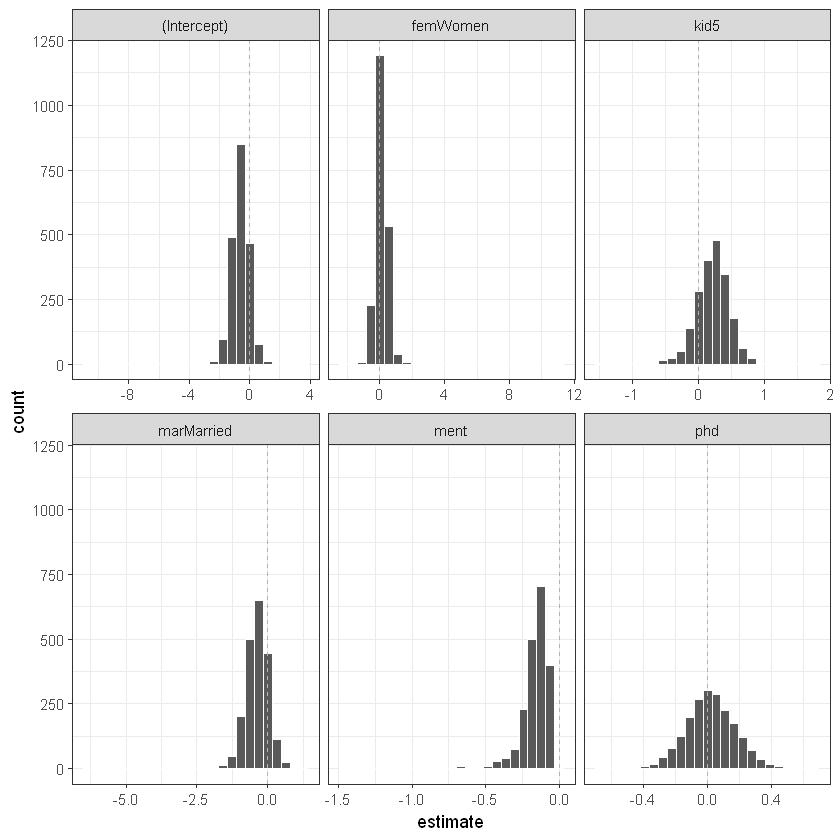

In [107]:
bootstrap_models %>% 
    unnest(zero_coefs) %>% 
    ggplot(aes(x = estimate)) +
    geom_histogram(bins = 25, color = "white") + 
    facet_wrap(~ term, scales = "free_x") + 
    geom_vline(xintercept = 0, lty = 2, color = "gray70")

#### 각 계수별 부트스트랩 분포에 대한 90% 신뢰구간
* 단순 분위수 기준

In [108]:
bootstrap_models %>% int_pctl(zero_coefs)

term,.lower,.estimate,.upper,.alpha,.method
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),-1.7501413,-0.62064615,0.42303185,0.05,percentile
femWomen,-0.5206851,0.11460779,0.81777870,0.05,percentile
kid5,-0.3271187,0.21750826,0.67680083,0.05,percentile
marMarried,-1.1976241,-0.38120660,0.36173155,0.05,percentile
ment,-0.4007909,-0.16226628,-0.05133433,0.05,percentile
phd,-0.2761738,0.02202415,0.32734463,0.05,percentile


- 표준오차에 기반한 t-분포 기준

In [109]:
bootstrap_models %>% int_t(zero_coefs)

term,.lower,.estimate,.upper,.alpha,.method
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),-1.6092848,-0.62064615,0.32145933,0.05,student-t
femWomen,-0.4820965,0.11460779,0.67112707,0.05,student-t
kid5,-0.2110739,0.21750826,0.59919229,0.05,student-t
marMarried,-0.9878914,-0.38120660,0.28955851,0.05,student-t
ment,-0.3235951,-0.16226628,-0.02753581,0.05,student-t
phd,-0.2738723,0.02202415,0.29060585,0.05,student-t
